In [1]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from abelfunctions import RiemannTheta

import layers as layers
import model as mdl

from costfunctions import MSE
import minimizer

In [3]:
M = mdl.Model()
M.add(layers.ThetaUnitLayer(1,3))
M.add(layers.ThetaUnitLayer(3,1))


In [9]:
def func(x):
    return np.sin(x)

X = np.linspace(0, 10, 100)
X = X.reshape((1,X.shape[0]))

Y = func(X[:,None]).reshape((1,X.shape[1]))

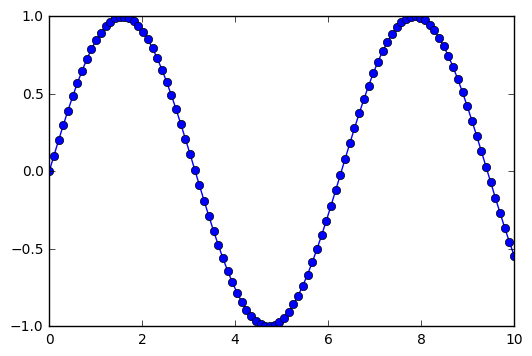

In [11]:
plt.plot(X.flatten(), Y.flatten(),"ob-")

In [13]:
minim = minimizer.CMA()
minim.set_costfunction(MSE)
minim.train(M, X, Y)

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 14 (seed=919035, Thu Oct 12 11:57:54 2017)


../rtbm.py:183: RuntimeWarning: overflow encountered in exp
  R = RiemannTheta(v/(2.0j * np.pi), -q/(2.0j * np.pi), prec=RTBM_precision)
../rtbm.py:183: RuntimeWarning: invalid value encountered in multiply
  R = RiemannTheta(v/(2.0j * np.pi), -q/(2.0j * np.pi), prec=RTBM_precision)
../rtbm.py:184: RuntimeWarning: overflow encountered in exp
  L = RiemannTheta(v/(2.0j * np.pi), -q/(2.0j * np.pi), prec=RTBM_precision, derivs=[D])
../rtbm.py:184: RuntimeWarning: overflow encountered in multiply
  L = RiemannTheta(v/(2.0j * np.pi), -q/(2.0j * np.pi), prec=RTBM_precision, derivs=[D])
../rtbm.py:184: RuntimeWarning: invalid value encountered in multiply
  L = RiemannTheta(v/(2.0j * np.pi), -q/(2.0j * np.pi), prec=RTBM_precision, derivs=[D])
../rtbm.py:188: RuntimeWarning: invalid value encountered in divide
  return -L/R/(2.0j * np.pi)


Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 1.177820337297528e+00 1.0e+00 9.09e-01  9e-01  9e-01 0:00.3


/Applications/SageMath-7.6.app/Contents/Resources/sage/local/lib/python2.7/site-packages/cma/evolution_strategy.py:3049: ComplexWarning: Casting complex values to real discards the imaginary part
  '%.15e' % (min(self.fit.fit)),
/Applications/SageMath-7.6.app/Contents/Resources/sage/local/lib/python2.7/site-packages/cma/evolution_strategy.py:4336: ComplexWarning: Casting complex values to real discards the imaginary part
  + '\n')
../rtbm.py:183: RuntimeWarning: overflow encountered in multiply
  R = RiemannTheta(v/(2.0j * np.pi), -q/(2.0j * np.pi), prec=RTBM_precision)


    2     22 3.349326182747717e+00 1.1e+00 8.89e-01  9e-01  9e-01 0:00.6
    3     33 4.994597479521300e+01 1.2e+00 9.28e-01  9e-01  1e+00 0:00.8
   16    176 5.981568100371385e-01 2.1e+00 1.17e+00  1e+00  1e+00 0:03.9
   35    385 4.055310793086270e-01 2.7e+00 1.10e+00  9e-01  1e+00 0:08.0
   58    638 3.874428504705911e-01 3.9e+00 7.92e-01  6e-01  1e+00 0:13.1
   86    946 2.768716457306213e-01 5.0e+00 6.95e-01  4e-01  8e-01 0:19.1
  100   1100 2.686958352994799e-01 6.1e+00 3.30e-01  2e-01  4e-01 0:22.1
  138   1518 5.883325782918387e-02 9.5e+00 4.45e-01  1e-01  6e-01 0:30.2
  180   1980 1.380687668334277e-02 1.3e+01 2.48e-01  6e-02  3e-01 0:39.2
  200   2200 1.083149663462415e-03 1.6e+01 1.18e-01  2e-02  1e-01 0:43.6
  250   2750 1.488310496807264e-04 2.6e+01 2.30e-02  4e-03  3e-02 0:54.6
  300   3300 1.005160125837045e-04 5.7e+01 8.97e-03  2e-03  1e-02 1:05.4
  361   3971 9.456568457804544e-05 1.4e+02 1.34e-02  2e-03  2e-02 1:18.5
  400   4400 8.954463620045082e-05 1.7e+02 8.34e-03

/Applications/SageMath-7.6.app/Contents/Resources/sage/local/lib/python2.7/site-packages/cma/evolution_strategy.py:2728: ComplexWarning: Casting complex values to real discards the imaginary part
  fbestever))


array([ -9.84235038e+00,  -2.03057446e+00,   4.11441277e+00,
         1.56675232e+00,   6.46257010e-01,   6.54644889e-01,
         9.86161698e+00,   4.06001732e+00,   4.11381628e+00,
        -9.67835547e+00,   6.25541829e-03,   6.44153767e+00,
        -6.44951079e+00,   3.15578581e-01])

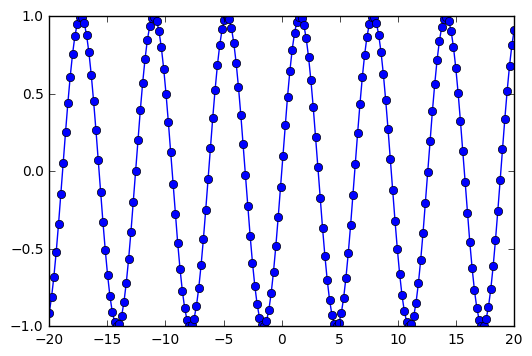

In [17]:
X = np.linspace(-20, 20, 200)
X = X.reshape((1,X.shape[0]))

plt.plot(X.flatten(), np.real(M.predict(X)).flatten(),"ob-")